# Part II - Prosper Loan Data Findings
### by Tristen Wallace

## Investigation Overview

Our presentation aims to showcase the impact of various borrower attributes, loan features, and specific time events on the distribution of Prosper loan listings. We'll begin by examining the listings from a univariate perspective, looking into the distrubtions of individual features.

Next, we'll enrich this analysis by introducing an additional attribute to these univariate distributions, observing how this changes the overall listing landscape.

Finally, our focus shifts to a more comprehensive multivariate approach. Here, we'll incorporate both Loan Amount and time series factors into our bivariate distributions, illustrating their combined effect on loan status.


## Dataset Overview

There are 74,019 loan listings in the dataset with 18 variables (excluding the ID variable for identifying loan listings) for our exploration. 

The variables are almost split between qualitative and quantitative. Of the quantitative features, there is one date (Loan Origination), two discrete (Term, InvestmentFromFriendsCount), and the rest are continuous. Of the qualitative, 2 are ordinal (IncomeRange, CreditRating), while the remaining are nominal.

In [2]:
# import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline

In [24]:
# load the clean dataset
df = pd.read_csv('../data/prosperLoanData_clean_v1.csv')

# Convert date to datetime
df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate)
df.rename(columns={'LoanOriginationDate':'Date'}, inplace=True)

# Convert credit types to relevant time period
df.CreditType.replace({'CreditGrade':'Before 2009-07','ProsperRating':'After 2009-07'}, inplace=True)
df.rename({'CreditType':'TimePeriod'}, axis=1, inplace=True)

# Map Listing Category codes to value names  
df.ListingCategory.replace({0:'No Occupation', 1:'Debt Consolidation', 2:'Home Improvement',
                        3:'Business', 4:'Personal', 6:'Auto', 7:'Other', 13:'Household' , 
                        15:'Medical' , 18:'Taxes' },inplace=True)   

# Create primary color for use in plots
color = sns.color_palette("Blues")[4]

## Distribution of Loan Categories

The most common loan category was `debt consolidation`, which accounted for 57% of loans. The second largest was `Other` at 13.7% (21% if you include `no occupation`), which is a modest size but we can't tell the real categories of this group. `Home Improvement` and `Business` were the next two most frequent categories, albeit much less common at 7.4% and 5.7% respectively.

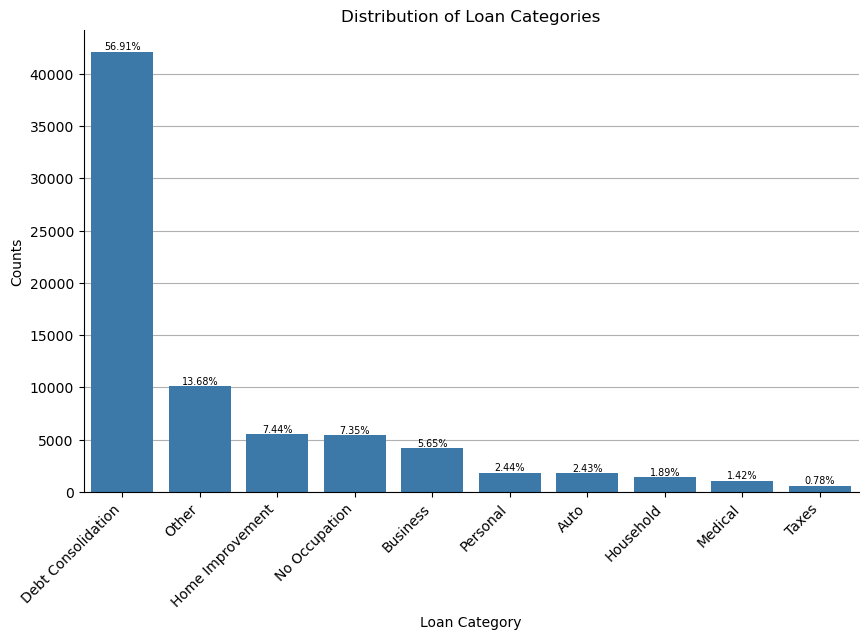

In [54]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Counts for categories, sliced for enumerate
lcat_cnt = df.ListingCategory.value_counts()

# % of total for categories
lcat_pct = df.ListingCategory.value_counts(normalize=True)*100
lcat_pct = lcat_pct.round(2)

# Plot bar chart for listing categories
g = sns.countplot(data=df, x="ListingCategory", color=color, order=lcat_cnt.index, zorder=2)

# Rotate x labels to fit
plt.xticks(rotation=45, ha='right');

# Set labels and titles
g.set(ylabel="Counts", xlabel="Loan Category", title="Distribution of Loan Categories")

# Add gridlines
g.yaxis.grid(zorder=0)

# Append % values as text to bars
for i, count in enumerate(lcat_cnt):
    pct_str = '{}%'.format(lcat_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');
    
sns.despine()

## Distribution of Loan Status

It's clear that a majority of loans (54.4%) are `Completed`, but oddly `Charged Off` and `Defaulted` statuses seem extremely high (40.8% combined). Taking into account that a majority of borrowers have higher incomes and medium-great credit ratings, it is worth exploring what could be causing such high delinquincy rates.

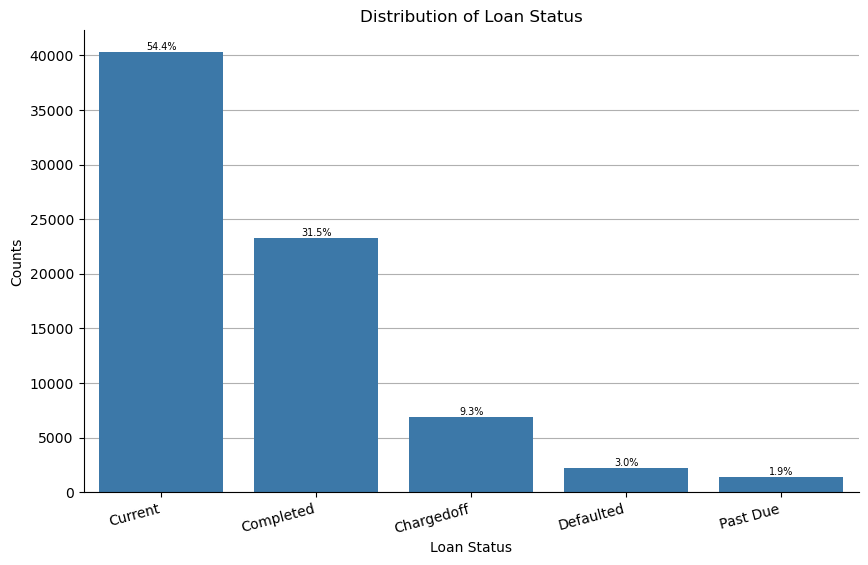

In [55]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Counts for statuses
s_cnt = df.LoanStatus.value_counts()

# % of total for statuses
s_pct = df.LoanStatus.value_counts(normalize=True)*100
s_pct = s_pct.round(1)

# Plot bar chart for status of loans
g = sns.countplot(data=df, x="LoanStatus", color=color, order=s_cnt.index, zorder=2)

# Rotate x labels to fit
plt.xticks(rotation=15, ha='right');

# Set labels and titles
g.set(ylabel="Counts", xlabel="Loan Status", title="Distribution of Loan Status")

# Add gridlines
g.yaxis.grid(zorder=0)

# Append % values as text to bars
for i, count in enumerate(s_cnt):
    pct_str = '{}%'.format(s_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');
    
sns.despine()

## Annual Count of Listing Category Faceted by Category

The faceted timelines above confirm our suspitions about the `Personal` and `No Occupation` categories; they both ceased to exist in 2008. 

It's also clear something weird was going on in 2009, possibly related to the end of the `Personal` category. The end of that catagory corresponds with a severe dip in the catagorization of other catagories and likely loans overall (but we'd have to check). Some other mildly interesting facts include the creation of several new catagories in 2012 and the explosion of `Debt Consolidation` loans from 2013-2014.

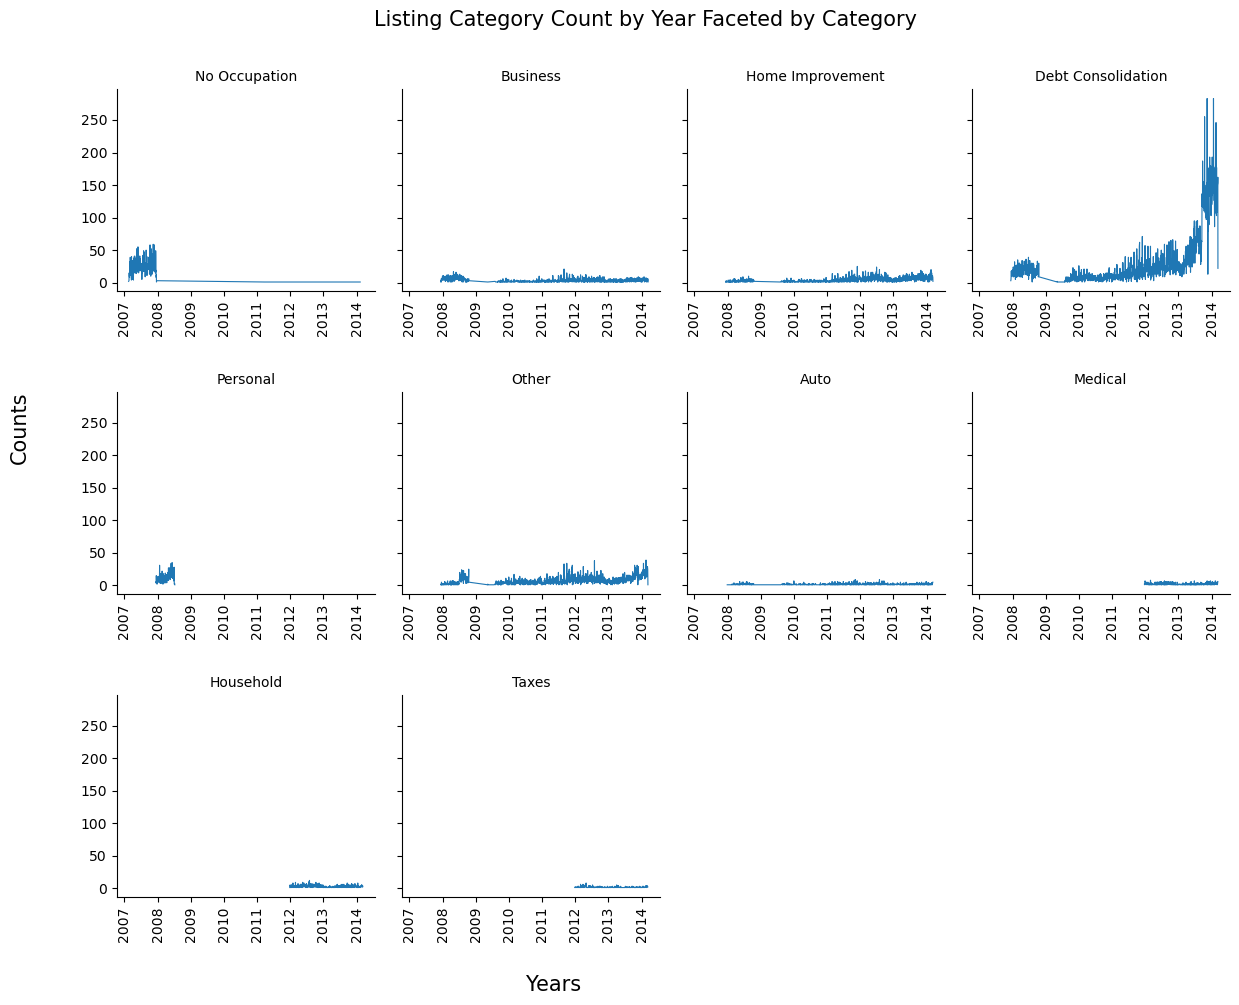

In [56]:
# Group listing category counts by date
cat_dates = df.groupby(['Date', 'ListingCategory']).size()
cat_dates = cat_dates.reset_index(drop=False)
cat_dates.rename(columns={0:'counts'}, inplace=True)


# Plot faceted bar plots
g = sns.FacetGrid(cat_dates, col='ListingCategory', col_wrap=4)
g.map(sns.lineplot, 'Date', 'counts', linewidth = .8)
plt.subplots_adjust(hspace=0.5)


# Rotate x ticks for legibility
for axis in g.axes.flat:
    axis.tick_params(axis='x', labelrotation=90, labelbottom=True)

# Set titles and labels
g.set_titles('{col_name}')
g.set(xlabel='', ylabel='')
plt.suptitle("Listing Category Count by Year Faceted by Category", fontsize=15, y=1.05)
g.fig.text(0.4, -0.04, s='Years',fontdict={'fontsize':15})
g.fig.text(-0.03, 0.55, s='Counts',fontdict={'fontsize':15}, rotation = 90);

## Loan Amount by Listing Category before/after 2009-07

We can see several interesting things occured after July 2009 

- There is no more listing amount in the `Personal` category.
- The mean values for the `No Occupation` category that we created dropped significantly, implying tighter restrictions on loan requirements. 
- New loan categories were created (`Medical`, `Taxes`, `Household`). Based on the cleaning stage, we know there could be others but their volumes were small enough to just include them in `Other`.
- The median listing amount in `Auto` category remained constant and increased across the `Debt Consolidation`, `Business`, `Home Imporvement`, and `Other` categories.

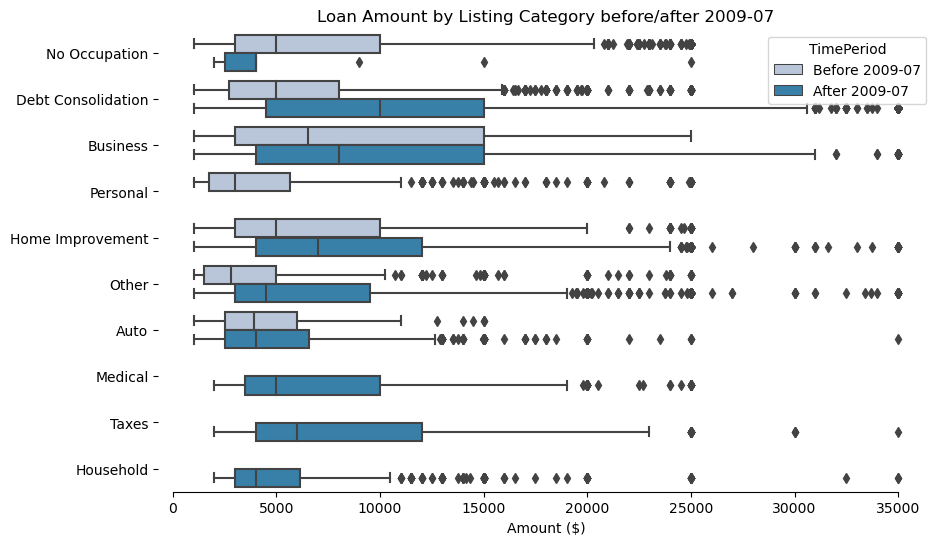

In [52]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.boxplot(data=df, x='LoanOriginalAmount', y='ListingCategory', hue='TimePeriod',
                palette='PuBu', orient='h')

# Set labels and title
g.set(ylabel="", xlabel="Amount ($)", title="Loan Amount by Listing Category before/after 2009-07")

# Remove border box
sns.despine(trim=True, left=True);

## Loan and Deliquency Trend

Prior to November 2008 there was a heavy concentration of delinquent loans.

Then we can see that there was a large gap in loan activity, which lines up with the SEC's cease and desist order issued to Prosper Marketplace in November 2008, and the relaunch of Prosper post-SEC intervention in July 2009. 

We can see that loan delinquencies decreased after the relaunch. As loan amounts and concentration increased in 2011 and 2012 there was an increase in the concentration of delinquencies, which drastically decreased by the end of 2013.

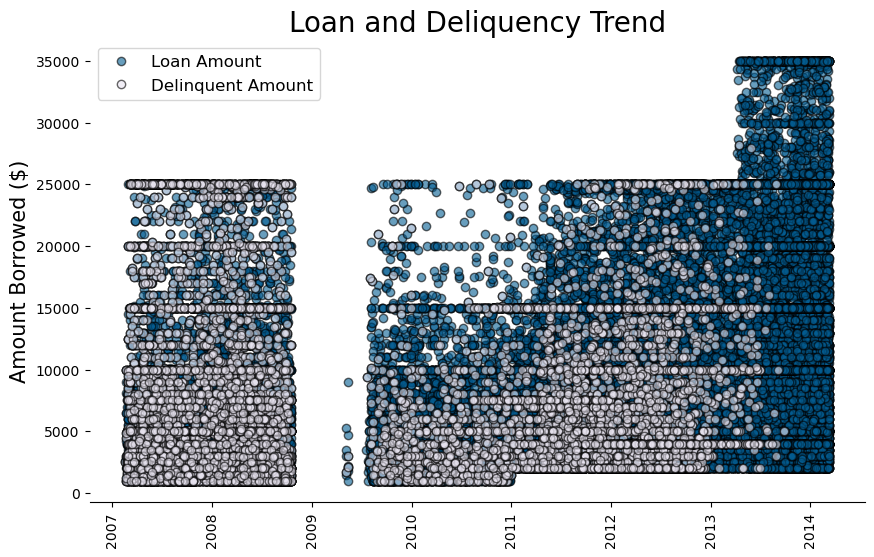

In [58]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot "outstanding balance" values
plt.plot(df.Date, df.TotalOutstanding, color=sns.color_palette("PuBu")[5],
                marker='o', mec='k', ms=6, alpha=0.6, linestyle='None', 
                label='Loan Amount')

# Plot delinquent values
plt.plot(df.Date, df.delinquent_amount, color=sns.color_palette("PuBu")[0],
                marker='o', mec='k', ms=6, alpha=0.6, linestyle='None', 
                label='Delinquent Amount')

# Set legend, labels and title
plt.legend(fontsize=12)
plt.ylabel('Amount Borrowed ($)', size=15)
plt.title('Loan and Deliquency Trend', size=20);
plt.xticks(rotation=90)

# Remove border box
sns.despine(left=True);